# Processing Symbolic Files with `music21`

In this notebook, we will explore how to process symbolic music files using the `music21` library. We will cover loading files, extracting musical features, and performing basic analyses.

More specifically, we will be processing `MIDI`, `MusicXML`, and `ABC` files to extract note sequences, durations, intervals, and other relevant musical information.

In [55]:
import time
import warnings
from collections import Counter
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from music21 import (
    chord,
    converter,
    environment,
    instrument,
    interval,
    key,
    meter,
    note,
    stream,
    tempo,
)

warnings.filterwarnings("ignore")

In [2]:
# define paths
DATA_PATH = Path("../data")
MIDI_PATH = DATA_PATH / "midi"
MUSICXML_PATH = DATA_PATH / "musicxml"
ABC_PATH = DATA_PATH / "abc"

In [3]:
# create lists of files
midi_files = sorted(glob(str(MIDI_PATH / "*.mid")))
musicxml_files = sorted(
    glob(str(MUSICXML_PATH / "*.mxl"))
)  # in the same folder you can find .musicxml files too (non-compressed)
abc_files = sorted(glob(str(ABC_PATH / "*.abc")))
print(
    f"Found {len(midi_files)} MIDI files."
    f"\nFound {len(musicxml_files)} MusicXML files."
    f"\nFound {len(abc_files)} ABC files."
)

Found 100 MIDI files.
Found 100 MusicXML files.
Found 100 ABC files.


In [4]:
# get the one file of each type
midi_sample = midi_files[0]
musicxml_sample = musicxml_files[12]  # get a score with multiple parts
abc_sample = abc_files[0]

print(
    f"\nMIDI sample file: {midi_sample}"
    f"\nMusicXML sample file: {musicxml_sample}"
    f"\nABC sample file: {abc_sample}"
)


MIDI sample file: ../data/midi/A_Kind_of_Magic.1.mid
MusicXML sample file: ../data/musicxml/QmPSRTz5UVFUVFWVABVjr5tV6QgpXaht6SteW7KCsxP8dL.mxl
ABC sample file: ../data/abc/tune_1.abc


## Parse Symbolic Files 

### Parse MIDI Files

In [5]:
midi_score = converter.parse(midi_sample)

print(f"Type: {type(midi_score)}")
print(f"Parts: {len(midi_score.parts)}")  # type: ignore
print(f"Duration: {midi_score.duration.quarterLength} quarters")

# MIDI files often have limited metadata
if midi_score.metadata:
    print(f"Title: {midi_score.metadata.title}")
    print(f"Composer: {midi_score.metadata.composer}")
else:
    print("No metadata available")

Type: <class 'music21.stream.base.Score'>
Parts: 1
Duration: 1336.0 quarters
Title: None
Composer: None


### Parse MusicXML Files

In [6]:
mxml_score = converter.parse(musicxml_sample)

print(f"Type: {type(mxml_score)}")
print(f"Parts: {len(mxml_score.parts)}")  # type: ignore
print(f"Duration: {mxml_score.duration.quarterLength} quarters")

# MusicXML typically has richer metadata
if mxml_score.metadata:
    print("\nMetadata:")
    print(f"  Title: {mxml_score.metadata.title}")
    print(f"  Composer: {mxml_score.metadata.composer}")
    print(f"  Copyright: {mxml_score.metadata.copyright}")

# Part information
print("\nParts:")
for i, part in enumerate(mxml_score.parts):  # type: ignore
    print(f"  Part {i}: {part.partName or 'Unnamed'}")

Type: <class 'music21.stream.base.Score'>
Parts: 2
Duration: 92.0 quarters

Metadata:
  Title: REEEEEEEEE
  Composer: Nathaniel A. Van Cleave
  Copyright: None

Parts:
  Part 0: Piano
  Part 1: Piano


### Parse ABC Files

In [7]:
abc_score = converter.parse(abc_sample)

print(f"Type: {type(abc_score)}")
print(f"Parts: {len(abc_score.parts)}")  # type: ignore
print(f"Duration: {abc_score.duration.quarterLength} quarters")

# ABC files contain metadata in headers
if abc_score.metadata:
    print("\nMetadata:")
    print(f"  Title: {abc_score.metadata.title}")
    print(f"  Composer: {abc_score.metadata.composer}")

Type: <class 'music21.stream.base.Score'>
Parts: 1
Duration: 48.0 quarters

Metadata:
  Title: Kennet Jig (For Kennet Mixer)
  Composer: None


## Explore Score Structure

Let's use one score as a sample to explore the structure of a `music21` score.

In [8]:
# Use MusicXML for detailed exploration
score = mxml_score

print(f"Score structure for: {score.metadata.title if score.metadata else 'Untitled'}")
print(f"Number of parts: {len(score.parts)}")  # type: ignore

# Examine each part
for i, part in enumerate(score.parts):  # type: ignore
    print(f"\n{'=' * 50}")
    print(f"Part {i}: {part.partName or 'Unnamed'}")
    print(f"{'=' * 50}")

    # Get instrument
    instruments = part.getElementsByClass(instrument.Instrument)
    if instruments:
        print(f"Instrument: {instruments[0].instrumentName}")

    # Count measures
    measures = part.getElementsByClass(stream.Measure)
    print(f"Measures: {len(measures)}")

    # Flatten to get all notes
    part_flat = part.flatten()
    notes = part_flat.notes
    print(f"Total notes/chords: {len(notes)}")

    # Get first few notes
    print("\nFirst 5 elements:")
    for j, n in enumerate(notes[:5]):
        if isinstance(n, note.Note):
            print(f"  {j + 1}. Note: {n.nameWithOctave}, duration: {n.quarterLength}")
        elif isinstance(n, chord.Chord):
            pitches = [p.nameWithOctave for p in n.pitches]
            print(f"  {j + 1}. Chord: {pitches}, duration: {n.quarterLength}")

Score structure for: REEEEEEEEE
Number of parts: 2

Part 0: Piano
Instrument: Piano
Measures: 23
Total notes/chords: 119

First 5 elements:
  1. Chord: ['D4', 'D5', 'A5'], duration: 0.5
  2. Chord: ['F4', 'F5'], duration: 0.5
  3. Chord: ['D4', 'A4', 'D5', 'A5'], duration: 0.5
  4. Chord: ['A4', 'F5'], duration: 0.5
  5. Chord: ['A#4', 'D5', 'A#5'], duration: 0.5

Part 1: Piano
Instrument: Piano
Measures: 23
Total notes/chords: 85

First 5 elements:
  1. Chord: ['D2', 'D3'], duration: 2.0
  2. Chord: ['A#1', 'F2'], duration: 2.0
  3. Chord: ['A1', 'A2'], duration: 4.0
  4. Note: F3, duration: 0.25
  5. Note: D3, duration: 0.25


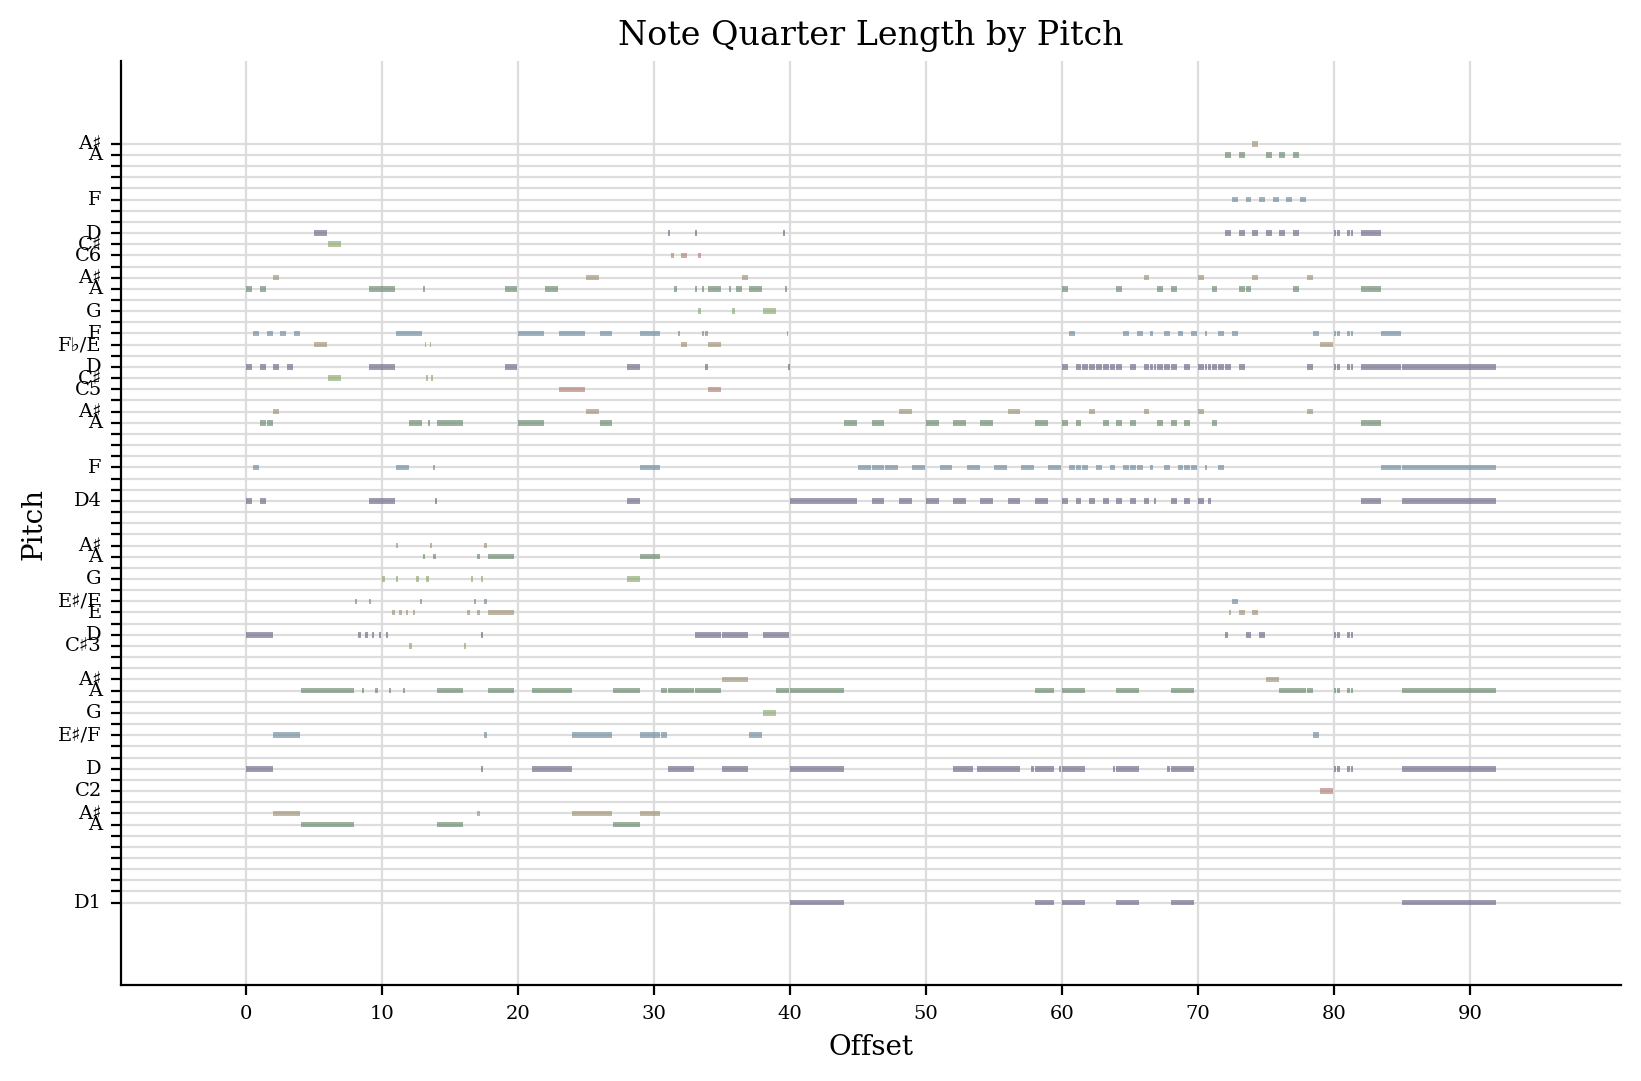

In [24]:
# plot a piano roll of the score
score.flatten().plot("pianoroll")

### Key and Time Signature

In [27]:
# Get key signature
keys = score.flatten().getElementsByClass(key.Key)  # type: ignore
if keys:
    print(f"Key signature: {keys[0]}")
else:
    # Analyze key if not explicitly set
    analyzed_key = score.analyze("key")
    print(f"Analyzed key: {analyzed_key}")

# Get time signature
time_sigs = score.flatten().getElementsByClass(meter.TimeSignature)  # type: ignore
if time_sigs:
    print(f"Time signature: {time_sigs[0]}")

# Get tempo markings
tempos = score.flatten().getElementsByClass(tempo.MetronomeMark)
if tempos:
    print(f"Tempo: {tempos[0].number} BPM")

Analyzed key: d minor
Time signature: <music21.meter.TimeSignature 4/4>
Tempo: 60 BPM


### Pitch Analysis

In [28]:
# Get all pitches from the first part
part = score.parts[0]  # type: ignore
flat_part = part.flatten()

# Extract all pitches
all_pitches = []
for n in flat_part.notes:
    if isinstance(n, note.Note):
        all_pitches.append(n.pitch)
    elif isinstance(n, chord.Chord):
        all_pitches.extend(n.pitches)

print(f"Total pitches: {len(all_pitches)}")

# Pitch range
if all_pitches:
    lowest = min(all_pitches)
    highest = max(all_pitches)
    print(f"Pitch range: {lowest.nameWithOctave} to {highest.nameWithOctave}")
    print(f"Range in semitones: {highest.midi - lowest.midi}")

# Pitch distribution
pitch_classes = [p.name for p in all_pitches]
pc_distribution = Counter(pitch_classes)

print("\nPitch class distribution:")
for pc, count in sorted(pc_distribution.items()):
    print(
        f"  Pitch class {pc.replace('-', 'b')}: {count}"
    )  # music21 uses '-' for flats!!!

Total pitches: 247
Pitch range: G3 to A#6
Range in semitones: 39

Pitch class distribution:
  Pitch class A: 52
  Pitch class A#: 16
  Pitch class C: 6
  Pitch class C#: 4
  Pitch class D: 88
  Pitch class E: 5
  Pitch class F: 71
  Pitch class Fb: 1
  Pitch class G: 4


### Rhythm Analysis

In [20]:
# Extract durations
durations = [n.quarterLength for n in flat_part.notesAndRests]

print(f"Total rhythmic events: {len(durations)}")
print(f"Unique durations: {sorted(set(durations))}")

# Duration distribution
duration_dist = Counter(durations)
print("\nMost common durations:")
for dur, count in duration_dist.most_common(5):
    print(f"  {dur} quarters: {count} times")

Total rhythmic events: 132
Unique durations: [0.125, 0.25, 0.5, 1.0, 1.5, 2.0, 4.0]

Most common durations:
  0.5 quarters: 54 times
  1.0 quarters: 40 times
  0.25 quarters: 18 times
  0.125 quarters: 12 times
  2.0 quarters: 4 times


### Interval Analysis

In [25]:
# Get melodic intervals (first part)
notes_only = [n for n in flat_part.notes if isinstance(n, note.Note)]

intervals_list = []
for i in range(len(notes_only) - 1):
    intv = interval.Interval(noteStart=notes_only[i], noteEnd=notes_only[i + 1])
    intervals_list.append(intv)

print(f"Total melodic intervals: {len(intervals_list)}")

# Interval distribution
interval_names = [intv.name for intv in intervals_list]
interval_dist = Counter(interval_names)

print("\nMost common intervals:")
for intv_name, count in interval_dist.most_common(5):
    print(f"  {intv_name}: {count}")

Total melodic intervals: 41

Most common intervals:
  P1: 10
  m3: 8
  M3: 5
  M2: 4
  P4: 3


## Batch Processing MusicXML Dataset

In [38]:
def analyze_score_comprehensive(filepath):
    """
    Extract comprehensive musical information from a score.

    Args:
        filepath: Path to the music file

    Returns:
        Dictionary with analysis results
    """
    try:
        score = converter.parse(filepath)
    except Exception as e:
        return {"error": str(e), "filename": Path(filepath).name}

    info: dict[str, object] = {
        "filename": Path(filepath).name,
        "format": Path(filepath).suffix,
    }

    # Basic information
    info["num_parts"] = len(score.parts) if hasattr(score, "parts") else 1  # type: ignore
    info["duration_quarters"] = score.duration.quarterLength

    # Metadata
    if score.metadata:
        info["title"] = score.metadata.title
        info["composer"] = score.metadata.composer
    else:
        info["title"] = None
        info["composer"] = None

    # Flatten score
    flat_score = score.flatten()

    # Count elements
    notes_and_chords = flat_score.notes
    info["num_notes"] = len(notes_and_chords)

    measures = flat_score.getElementsByClass(stream.Measure)
    info["num_measures"] = len(measures)

    # Pitch information
    all_pitches = []
    for n in notes_and_chords:
        if isinstance(n, note.Note):
            all_pitches.append(n.pitch)
        elif isinstance(n, chord.Chord):
            all_pitches.extend(n.pitches)

    if all_pitches:
        info["lowest_pitch"] = min(all_pitches).nameWithOctave
        info["highest_pitch"] = max(all_pitches).nameWithOctave
        info["range_semitones"] = max(p.midi for p in all_pitches) - min(
            p.midi for p in all_pitches
        )
    else:
        info["lowest_pitch"] = None
        info["highest_pitch"] = None
        info["range_semitones"] = None

    # Time signature
    time_sigs = flat_score.getElementsByClass(meter.TimeSignature)  # type: ignore
    info["time_signature"] = (
        f"{time_sigs[0].numerator}/{time_sigs[0].denominator}" if time_sigs else None
    )

    # Key signature
    keys = flat_score.getElementsByClass(key.Key)
    if keys:
        info["key"] = str(keys[0])
    else:
        try:
            analyzed_key = score.analyze("key")
            info["key"] = str(analyzed_key)
        except Exception:
            info["key"] = None

    # Tempo
    tempos = flat_score.getElementsByClass(tempo.MetronomeMark)
    info["tempo_bpm"] = tempos[0].number if tempos else None

    return info

In [39]:
# Process MusicXML files (more reliable than MIDI)
print("Processing MusicXML files...")

results = []
errors = []

# set a time counter to measure processing time
start_time = time.time()

# Process first 20 files (adjust as needed)
for filepath in musicxml_files:
    analysis = analyze_score_comprehensive(filepath)

    if "error" in analysis:
        errors.append(analysis)
    else:
        results.append(analysis)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Processed {len(musicxml_files)} files in {elapsed_time:.2f} seconds.")

print(f"\nSuccessfully processed: {len(results)}")
print(f"Errors: {len(errors)}")

Processing MusicXML files...
Processed 100 files in 3.47 seconds.

Successfully processed: 100
Errors: 0


In [40]:
# Create DataFrame
df = pd.DataFrame(results)

print("\nBasic Statistics")
print("=" * 40)

# Duration statistics
print("\nDuration (quarter notes):")
print(f"  Mean: {df['duration_quarters'].mean():.2f}")
print(f"  Median: {df['duration_quarters'].median():.2f}")
print(f"  Min: {df['duration_quarters'].min():.2f}")
print(f"  Max: {df['duration_quarters'].max():.2f}")

# Number of notes
print("\nNumber of notes:")
print(f"  Mean: {df['num_notes'].mean():.2f}")
print(f"  Median: {df['num_notes'].median():.2f}")
print(f"  Min: {df['num_notes'].min()}")
print(f"  Max: {df['num_notes'].max()}")

# Pitch range
print("\nPitch range (semitones):")
print(f"  Mean: {df['range_semitones'].mean():.2f}")
print(f"  Median: {df['range_semitones'].median():.2f}")
print(f"  Min: {df['range_semitones'].min()}")
print(f"  Max: {df['range_semitones'].max()}")


Basic Statistics

Duration (quarter notes):
  Mean: 132.45
  Median: 64.00
  Min: 19.50
  Max: 3712.00

Number of notes:
  Mean: 312.49
  Median: 114.00
  Min: 40
  Max: 9701

Pitch range (semitones):
  Mean: 26.46
  Median: 21.00
  Min: 8
  Max: 102


In [41]:
# Key Signature Distribution
key_counts = df["key"].value_counts()

print("\nKey Distribution:")
print("=" * 60)
for key_sig, count in key_counts.head(10).items():
    print(f"  {key_sig}: {count}")

# Time Signature Distribution
ts_counts = df["time_signature"].value_counts()

print("\nTime Signature Distribution:")
print("=" * 60)
for ts, count in ts_counts.items():
    print(f"  {ts}: {count}")

# Tempo Distribution
tempo_data = df[df["tempo_bpm"].notna()]

if len(tempo_data) > 0:
    print("\nTempo Distribution (BPM):")
    print("=" * 60)
    print(f"  Mean: {tempo_data['tempo_bpm'].mean():.2f}")
    print(f"  Median: {tempo_data['tempo_bpm'].median():.2f}")
    print(f"  Min: {tempo_data['tempo_bpm'].min():.2f}")
    print(f"  Max: {tempo_data['tempo_bpm'].max():.2f}")
else:
    print("\nNo tempo information available in dataset")


Key Distribution:
  G major: 21
  D major: 20
  a minor: 10
  A major: 8
  C major: 7
  F major: 7
  B- major: 6
  d minor: 5
  b minor: 2
  g minor: 2

Time Signature Distribution:
  4/4: 40
  6/8: 15
  2/2: 14
  3/4: 11
  2/4: 7
  3/8: 6
  6/4: 4
  14/4: 1
  9/8: 1
  5/4: 1

Tempo Distribution (BPM):
  Mean: 104.49
  Median: 100.00
  Min: 40.00
  Max: 300.00


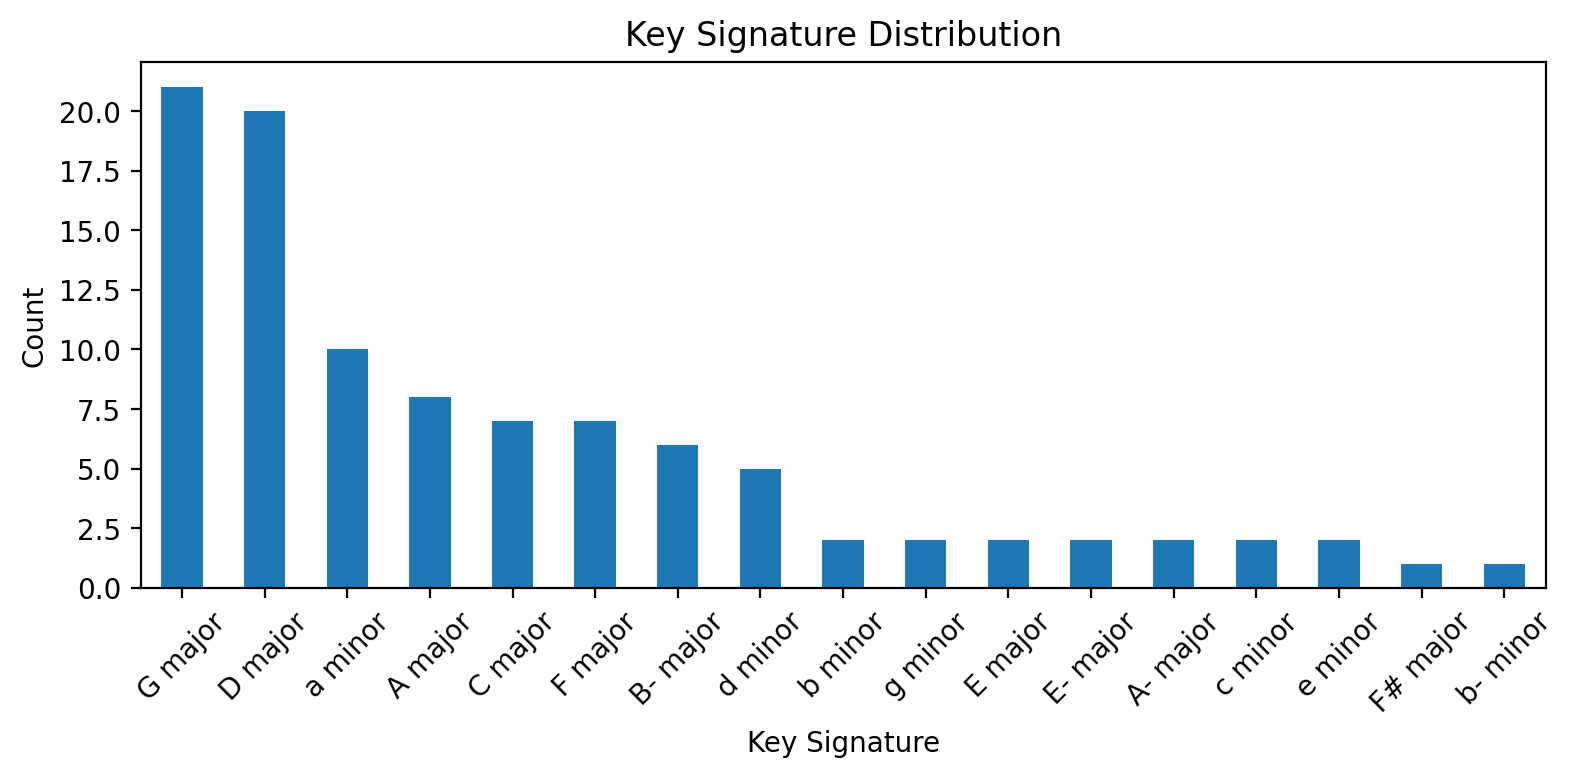

In [44]:
# plot key distribution
plt.figure(figsize=(8, 4))
key_counts.plot(kind="bar")
plt.title("Key Signature Distribution")
plt.xlabel("Key Signature")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

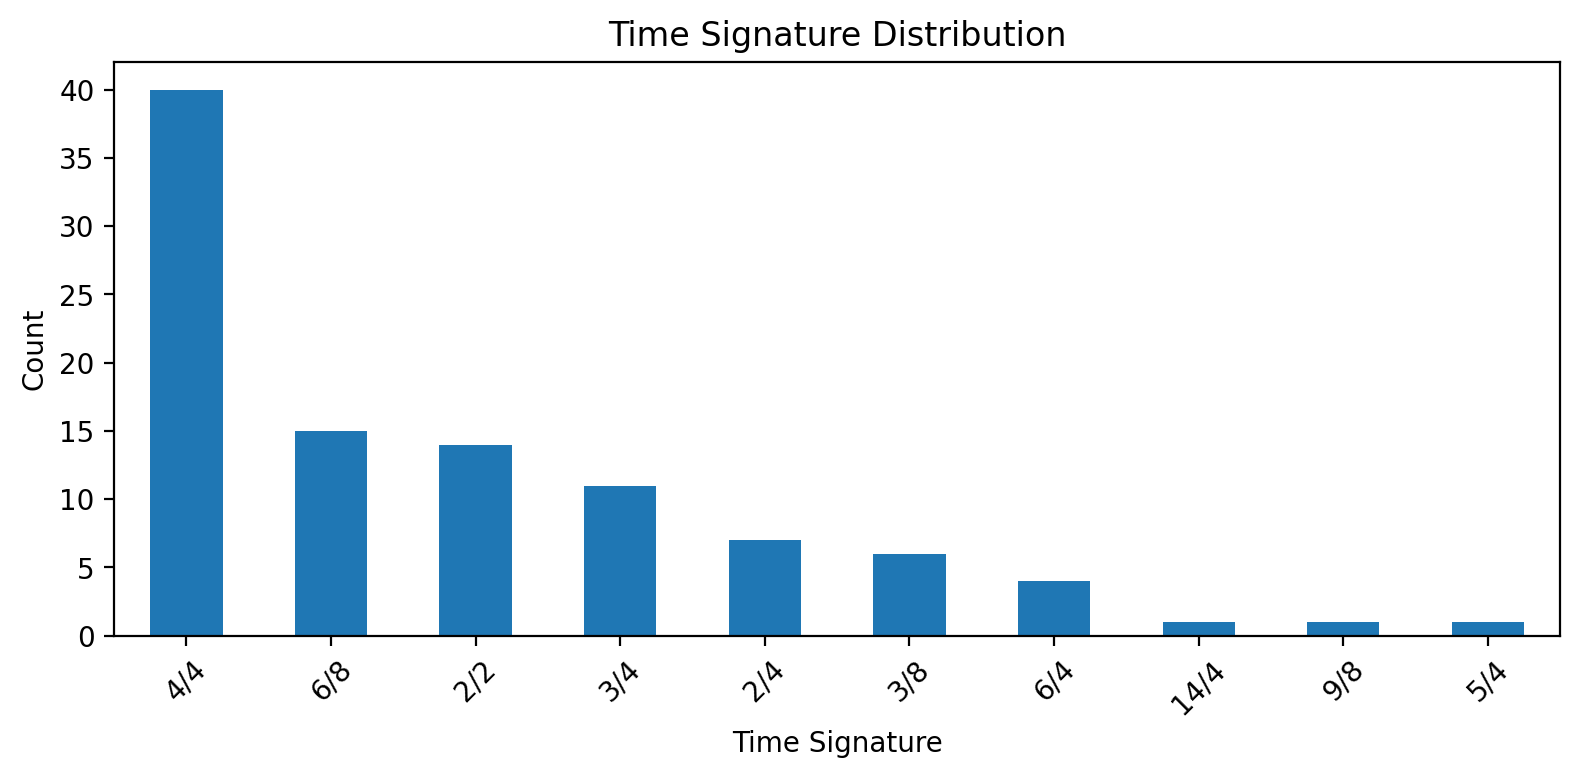

In [ ]:
# plot time signature distribution
plt.figure(figsize=(8, 4))
ts_counts.plot(kind="bar")
plt.title("Time Signature Distribution")
plt.xlabel("Time Signature")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

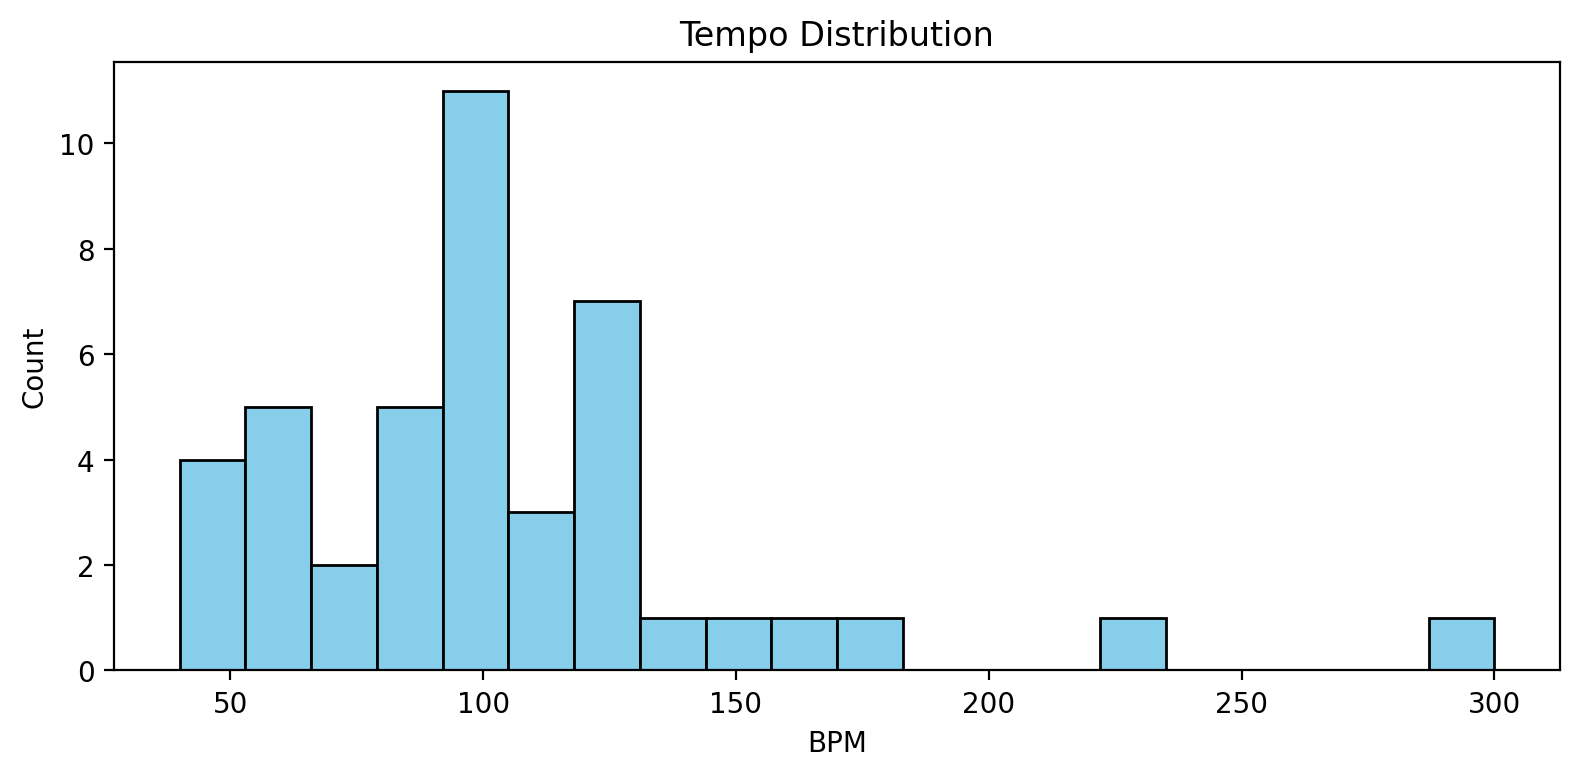

In [46]:
# plot tempos
plt.figure(figsize=(8, 4))
plt.hist(tempo_data["tempo_bpm"], bins=20, color="skyblue", edgecolor="black")
plt.title("Tempo Distribution")
plt.xlabel("BPM")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

## Symbolic Format Coversion

Let's check what happens when we convert between different symbolic formats using `music21`.
In particular, let's try to convert a `MusicXML` file to `MIDI` and examine the what can get lost in the conversion.

In order to be able to visualize the results, we will use `music21`'s built-in `show()` method to display the scores. 
Check the notebook `02` for more details on how to use configure `music21` for visualization.

In [ ]:
# For reference, in case you need to set up MuseScore path

# Check current environment settings
env = environment.Environment()

# Choose the code for your operating system:

## === WINDOWS ===
## Most common path for MuseScore 4
# env["musescoreDirectPNGPath"] = r"C:\Program Files\MuseScore 4\bin\MuseScore4.exe"

## If you have MuseScore 3
# env["musescoreDirectPNGPath"] = r"C:\Program Files\MuseScore 3\bin\MuseScore3.exe"

## === macOS ===
# env["musescoreDirectPNGPath"] = "/Applications/MuseScore 4.app/Contents/MacOS/mscore"

## === Linux ===
# env["musescoreDirectPNGPath"] = "/usr/bin/musescore"

## === LINUX (AppImage) ===
## grant execute permissions to the AppImage if not already done:
## !chmod +x ~/Downloads/MuseScore-Studio-4.6.5.253511702-x86_64.AppImage
# env["musescoreDirectPNGPath"] = (
#     "~/Downloads/MuseScore-Studio-4.6.5.253511702-x86_64.AppImage"
# )


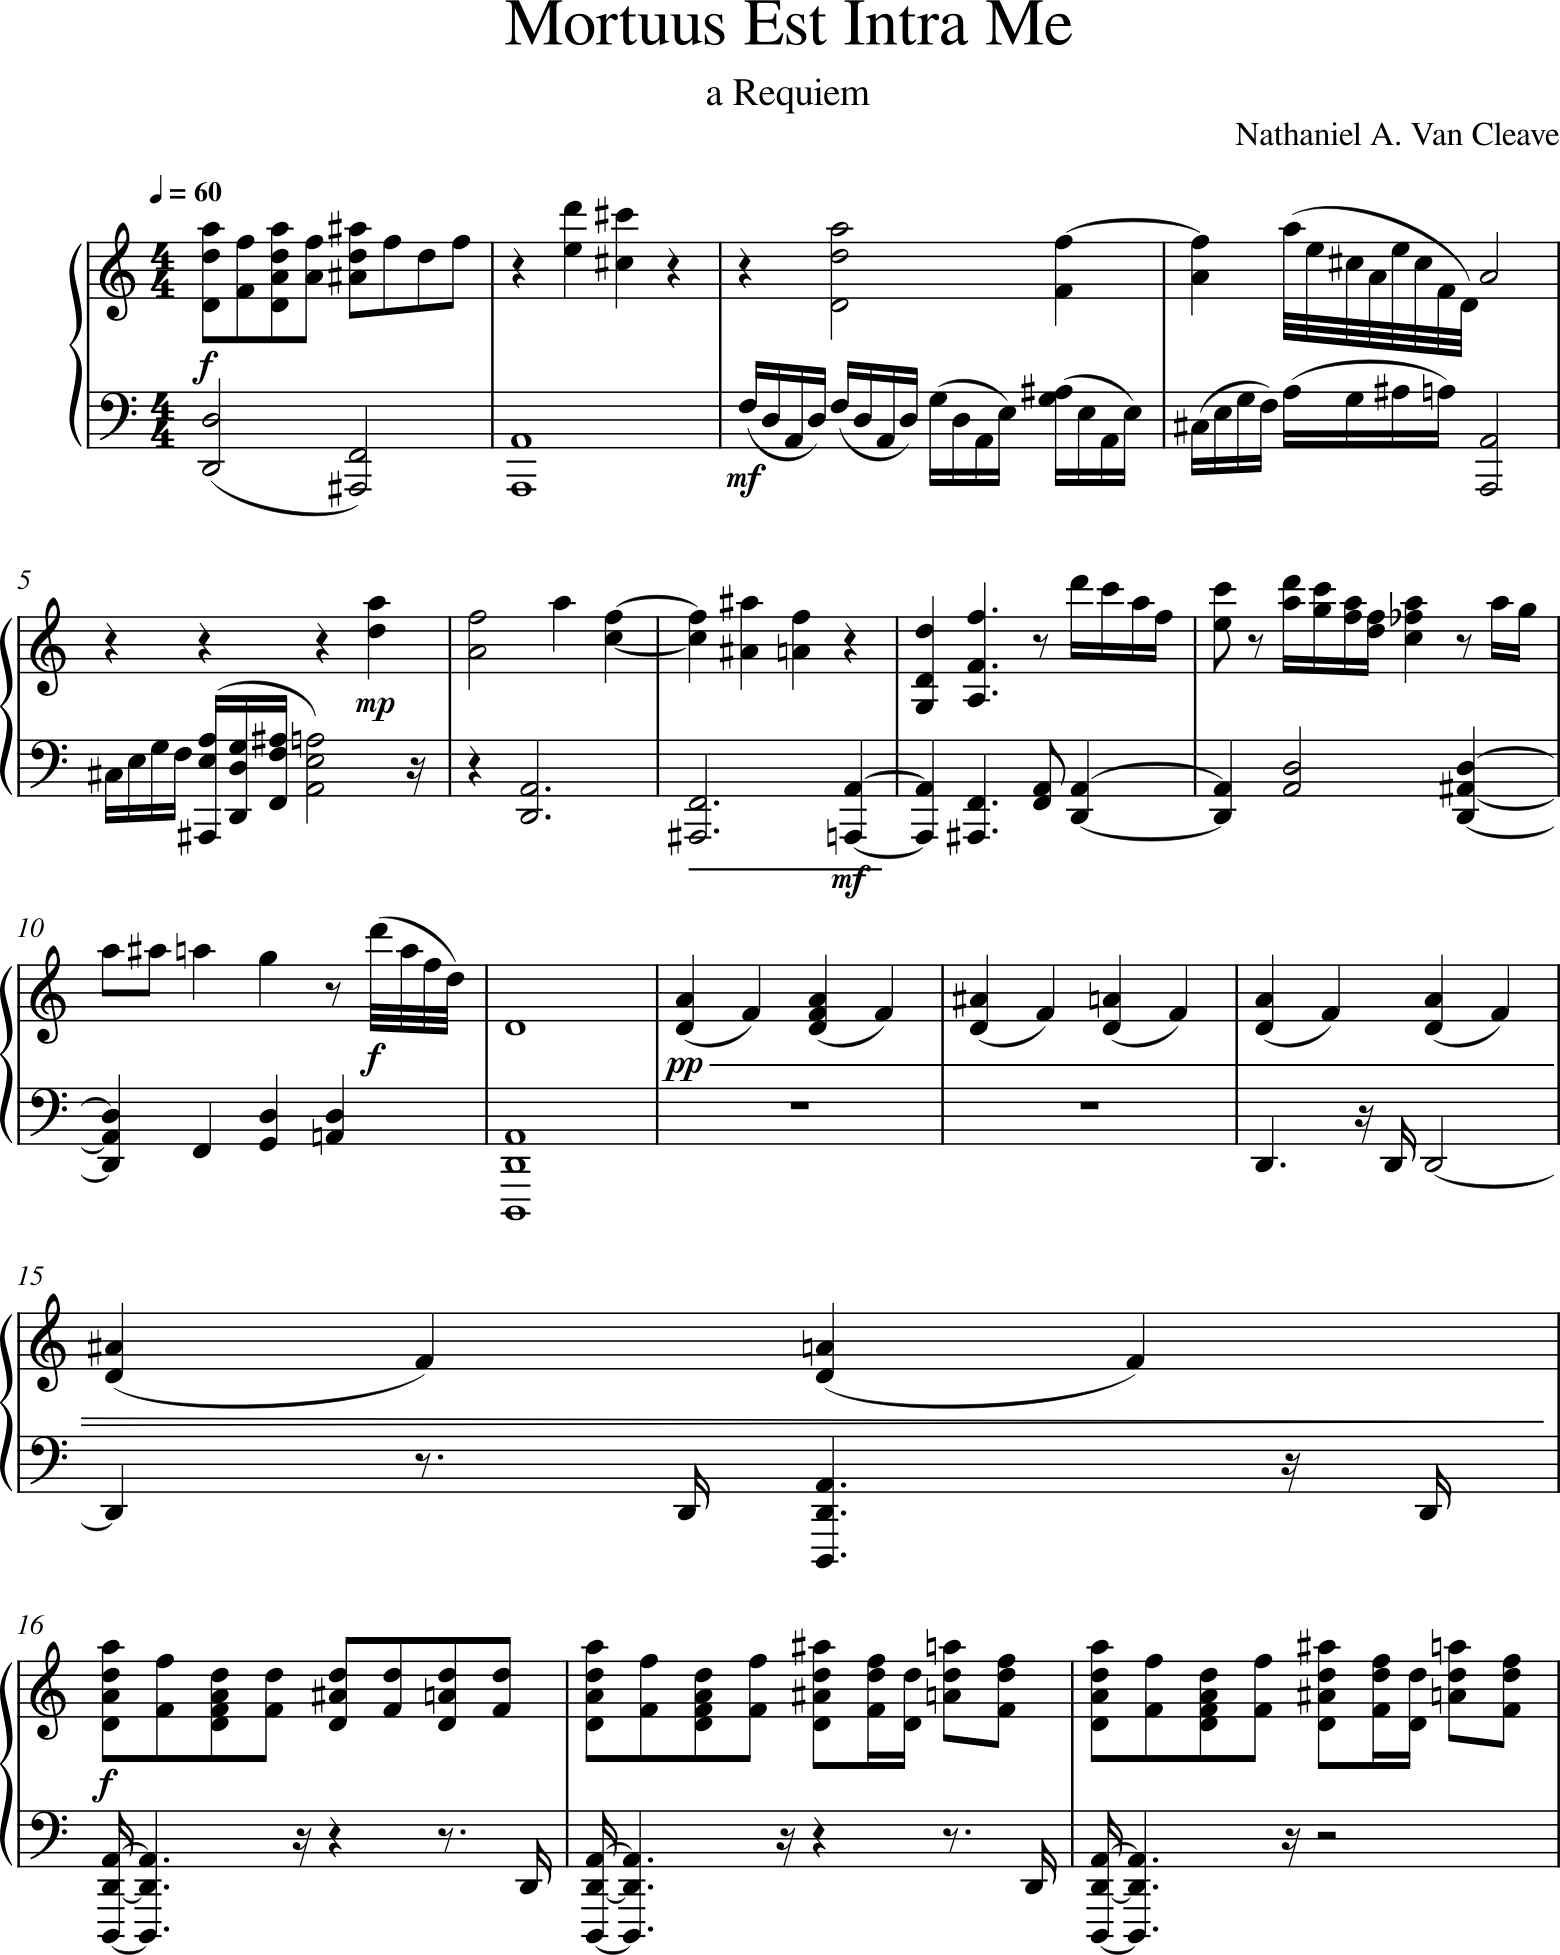

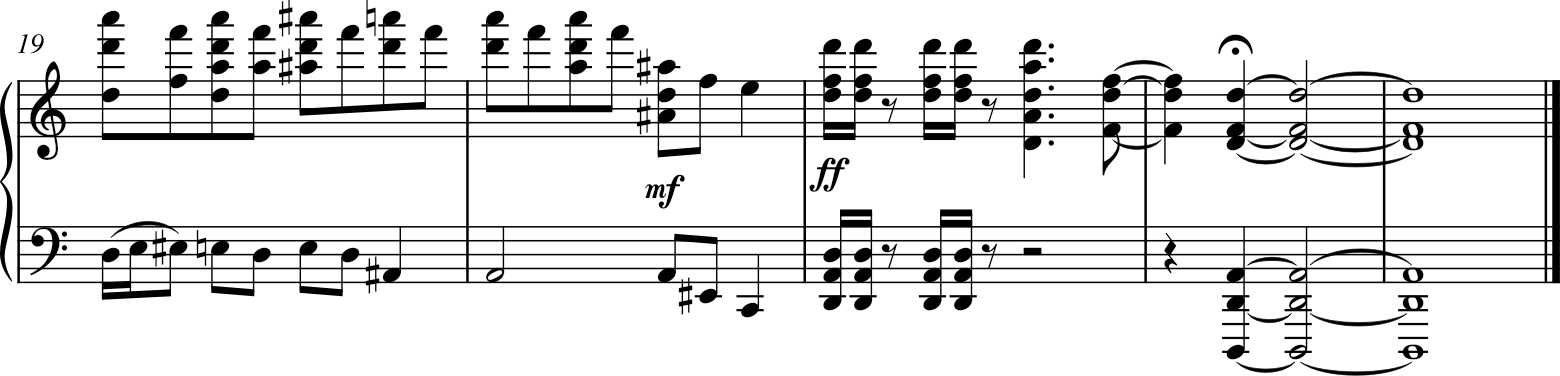

In [74]:
# get the musicxml sample file, parse it (again) and show it
score = converter.parse(musicxml_files[12])
score.show()

In [65]:
# convert the score to MIDI
# Define output path
midi_output = "converted_score.mid"

# Write to MIDI
score.write("midi", fp=midi_output)

print(f"Converted to MIDI: {midi_output}")


Converted to MIDI: converted_score.mid


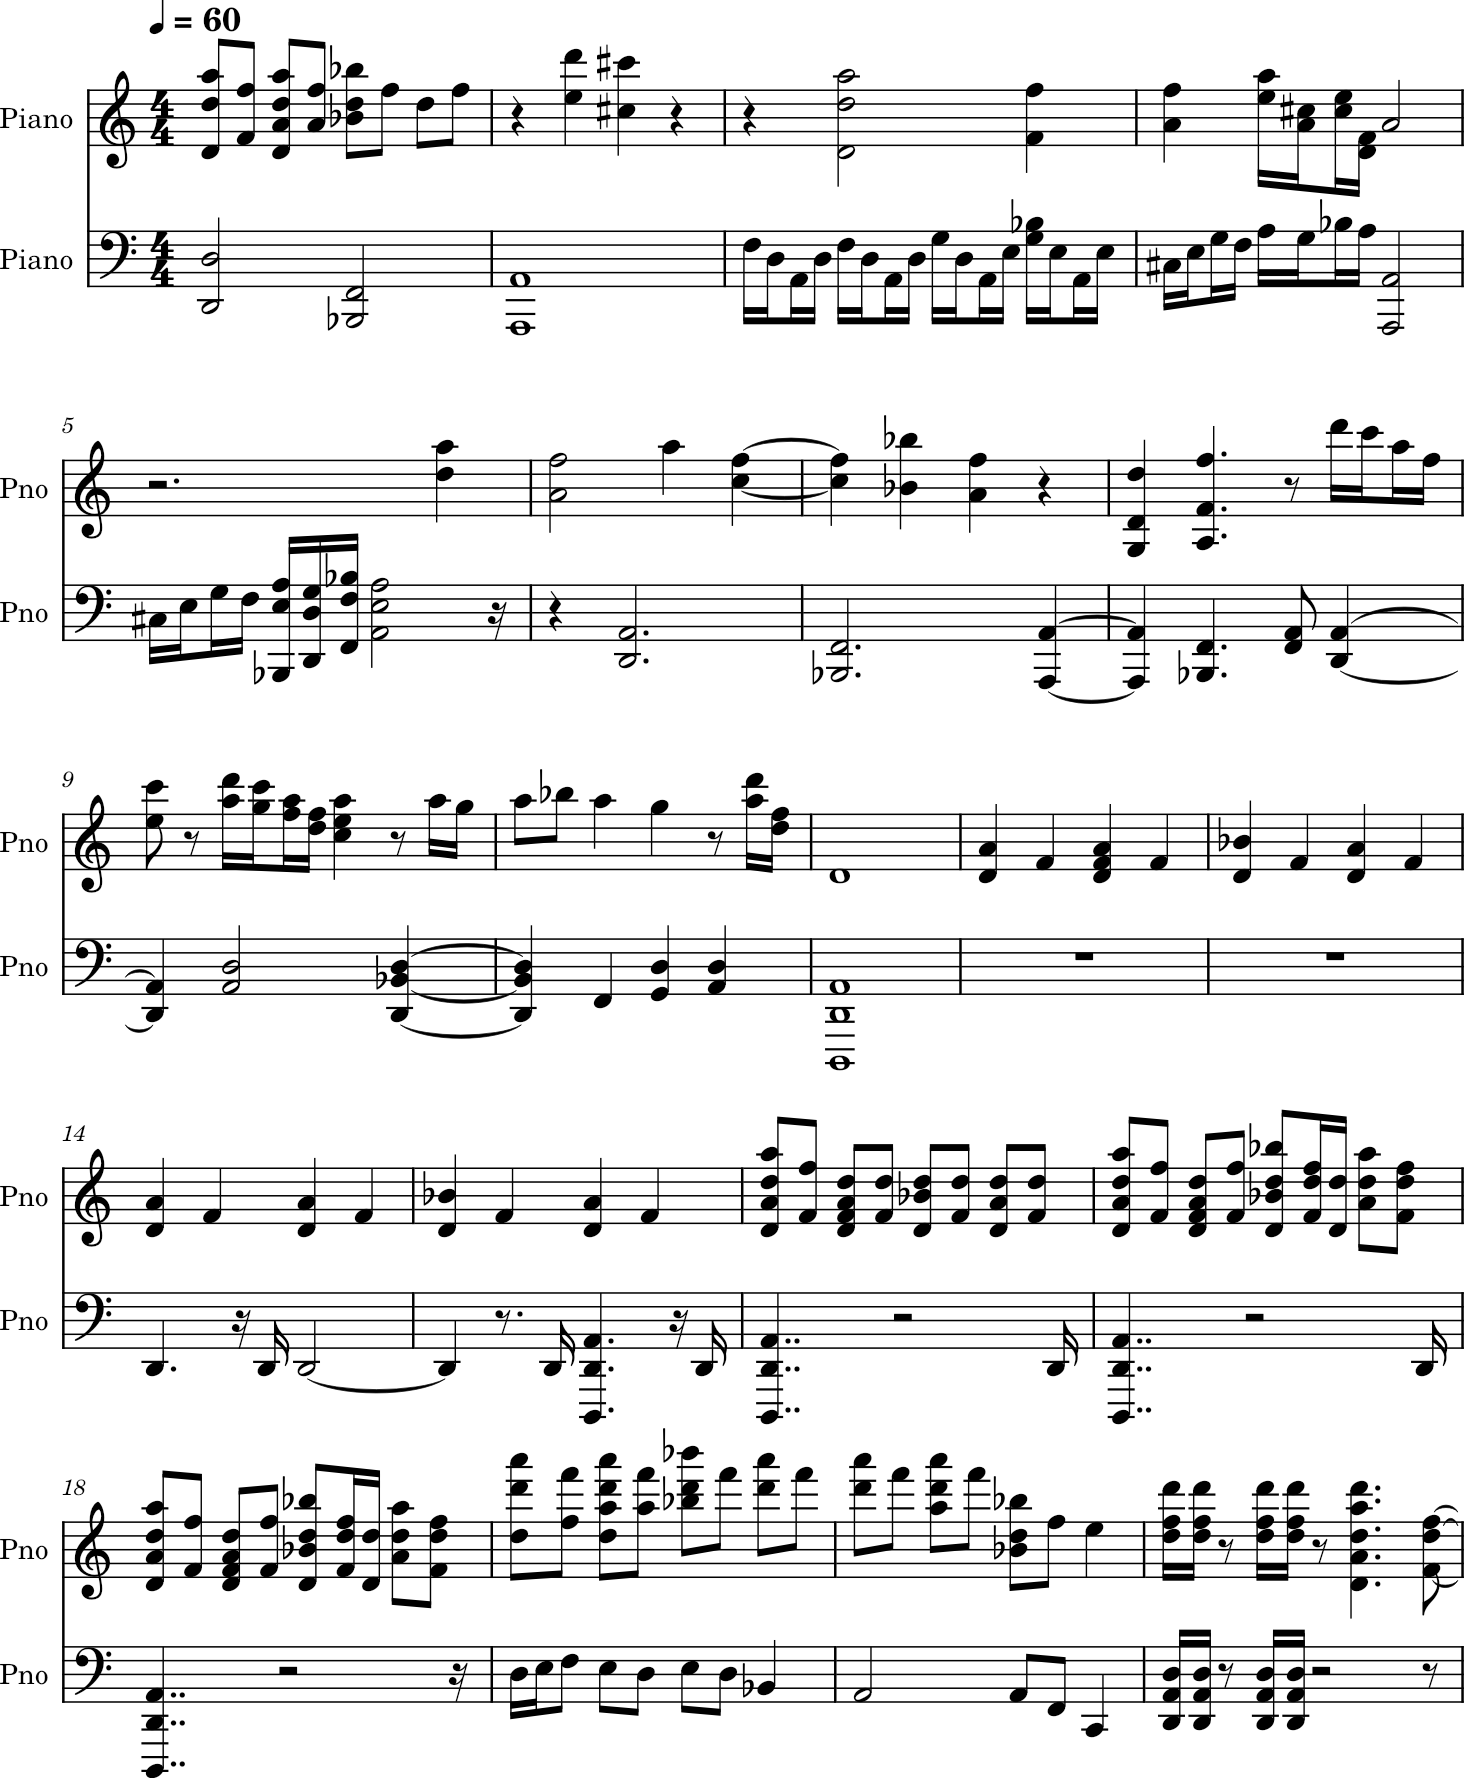

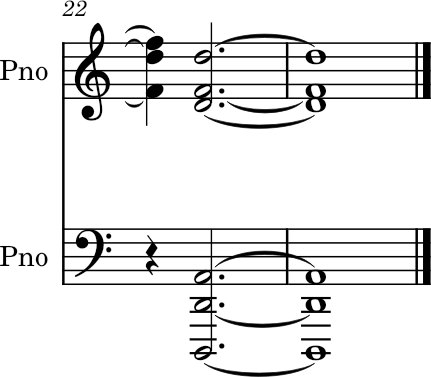

In [67]:
# show the midi file
midi_score = converter.parse(midi_output)
midi_score.show()